In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from mpl_toolkits.axes_grid1 import ImageGrid
plt.ion()
from torch.utils.data.sampler import SubsetRandomSampler
#%matplotlib inline

In [3]:
# Data augmentation and normalization for training 
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ])    
}

In [4]:
#image_dataset Attributes:
# classes (list): List of the class names.
# class_to_idx (dict): Dict with items (class_name, class_index).
# imgs (list): List of (image path, class_index) tuples
            
#data_dir='/home/mnt/jupyter_dir/hymenoptera_data'
data_dir='/home/mnt/jupyter_dir/imagewoof'
#data_dir='/home/mnt/jupyter_dir/tiny-imagenet-200'
#data_dir='/home/mnt/jupyter_dir/stanford-cars'
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), 
                        data_transforms[x]) for x in ['train', 'val'] }

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 12454
     Root location: /home/mnt/jupyter_dir/imagewoof/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 500
     Root location: /home/mnt/jupyter_dir/imagewoof/val
     StandardTransform
 Transform: Compose(
                Resize(size=100, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(100, 100))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [52]:
dataloaders= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, 
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val'] }
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

inputs.size()

torch.Size([16, 3, 100, 100])

In [31]:
class_names

['n02086240',
 'n02087394',
 'n02088364',
 'n02089973',
 'n02093754',
 'n02096294',
 'n02099601',
 'n02105641',
 'n02111889',
 'n02115641']

In [8]:
#plot each image using grid axis 
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow((inp * 255).astype(np.uint8))

torch.Size([16, 3, 224, 224]) torch.Size([16])


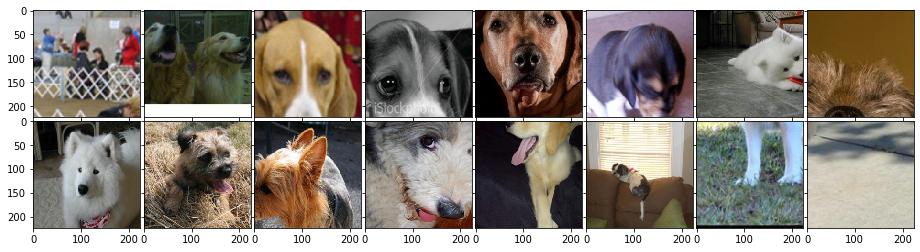

In [9]:
train = dataloaders['train']
# Get a batch of training data with labels
img, label = next(iter(train))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
#make a grid of (2,8)
grid = ImageGrid(fig, 111, nrows_ncols=(2, 8), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [32]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, flag_Load=True):
    
    since= time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    
    for epoch in range(num_epochs-1):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'* 10)
        # load the model from disk if flag_Load is True
        if flag_Load==True:
            print('Loading model from disk')
            flag_Load=False
            checkpoint = torch.load('/home/mnt/jupyter_dir/saved_model_dog/resnet101_28.pth.tar')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            best_acc = checkpoint['best_prec1']
            
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            
            if phase == 'train':
                
                scheduler.step()
                model.train() # set model to training mode
            else:
                
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc> best_acc:
                #print('input shape for validation', inputs.shape)
                best_acc= epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
            print()
            #save number of epochs, model weights, optimization hyper-parameters, loss and best_acc each epoch 
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'best_prec1': best_acc}, '/home/mnt/jupyter_dir/saved_model_dog/resnet101_'+str(epoch)+'.pth.tar')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best val Acc : {:4f}'.format(best_acc))
    
    #save entire model
    torch.save(model,'/home/mnt/jupyter_dir/saved_model_dog/resnet101.pth.tar')
    
    # load best weights
    model.load_state_dict(best_model_wts)
    
    return model

In [36]:
model_conv = torchvision.models.resnet152(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50, flag_Load=True)

Epoch 0/49
----------
Loading model from disk
train Loss: 0.3243 Acc: 0.8934

val Loss: 0.2120 Acc: 0.9340

Epoch 1/49
----------
train Loss: 0.3302 Acc: 0.8922

val Loss: 0.2042 Acc: 0.9360

Epoch 2/49
----------
train Loss: 0.3204 Acc: 0.8908

val Loss: 0.2044 Acc: 0.9340

Epoch 3/49
----------
train Loss: 0.3343 Acc: 0.8910

val Loss: 0.2119 Acc: 0.9340

Epoch 4/49
----------
train Loss: 0.3256 Acc: 0.8941

val Loss: 0.2102 Acc: 0.9360

Epoch 5/49
----------
train Loss: 0.3252 Acc: 0.8910

val Loss: 0.2022 Acc: 0.9320

Epoch 6/49
----------
train Loss: 0.3279 Acc: 0.8909

val Loss: 0.2128 Acc: 0.9380

Epoch 7/49
----------
train Loss: 0.3277 Acc: 0.8918

val Loss: 0.2195 Acc: 0.9260

Epoch 8/49
----------
train Loss: 0.3241 Acc: 0.8922

val Loss: 0.2051 Acc: 0.9400

Epoch 9/49
----------
train Loss: 0.3242 Acc: 0.8938

val Loss: 0.2100 Acc: 0.9360

Epoch 10/49
----------
train Loss: 0.3195 Acc: 0.8931

val Loss: 0.2118 Acc: 0.9400

Epoch 11/49
----------
train Loss: 0.3205 Acc: 0.89

In [34]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [37]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30, flag_Load=False)

Epoch 0/29
----------
train Loss: 0.5785 Acc: 0.8421

val Loss: 0.2896 Acc: 0.8960

Epoch 1/29
----------
train Loss: 0.3790 Acc: 0.8786

val Loss: 0.2675 Acc: 0.9120

Epoch 2/29
----------
train Loss: 0.3644 Acc: 0.8795

val Loss: 0.2907 Acc: 0.9060

Epoch 3/29
----------
train Loss: 0.3601 Acc: 0.8829

val Loss: 0.2625 Acc: 0.9240

Epoch 4/29
----------
train Loss: 0.3543 Acc: 0.8845

val Loss: 0.2546 Acc: 0.9220

Epoch 5/29
----------
train Loss: 0.3468 Acc: 0.8828

val Loss: 0.2711 Acc: 0.9240

Epoch 6/29
----------
train Loss: 0.3561 Acc: 0.8827

val Loss: 0.2931 Acc: 0.9120

Epoch 7/29
----------
train Loss: 0.3532 Acc: 0.8829

val Loss: 0.2793 Acc: 0.9200

Epoch 8/29
----------
train Loss: 0.3338 Acc: 0.8915

val Loss: 0.2572 Acc: 0.9240

Epoch 9/29
----------
train Loss: 0.3341 Acc: 0.8906

val Loss: 0.2578 Acc: 0.9220

Epoch 10/29
----------
train Loss: 0.3253 Acc: 0.8925

val Loss: 0.2836 Acc: 0.9200

Epoch 11/29
----------
train Loss: 0.3306 Acc: 0.8906

val Loss: 0.2706 Acc

In [54]:
model_conv.eval()
running_corrects = 0.0
since = time.time()
for inputs, labels in dataloaders['val']:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_conv(inputs)
    #out = torch.squeeze(outputs, dim=2)
    #out2 = torch.squeeze(out, dim=2)
    _, preds = torch.max(outputs,1)
    
    # statistics
    #preds =torch.mean(preds.float(), dim=2,keepdim=True)
    #preds =torch.mean(preds.float(), dim=1,keepdim=True)
    #print(preds)
    running_corrects += torch.sum(preds.long()==labels.data)

acc = running_corrects.double() / dataset_sizes['val']
print('{} Acc: {:.4f}'.format("Testing", acc))
print()
time_elapsed = time.time() - since
print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  

Testing Acc: 0.8100

Testing complete in 0m 4s


In [ ]:
def validate(val_loader, model, criterion, args):

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
            target = target.cuda(args.gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

In [ ]:
def test_sumission(model):
    since = time.time()
    sub_outputs = []
    model.train(False)  # Set model to evaluate mode
    # Iterate over data.
    for data in sub_loader:
        # get the inputs
        inputs, labels = data

        inputs = Variable(inputs.type(Tensor))
        labels = Variable(labels.type(LongTensor))

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        sub_outputs.append(outputs.data.cpu().numpy())

    sub_outputs = np.concatenate(sub_outputs)
    for idx,row in enumerate(sub_outputs.astype(float)):
        sub_outputs[idx] = np.exp(row)/np.sum(np.exp(row))

    output_df.loc[:,1:] = sub_outputs
        
    print()
    time_elapsed = time.time() - since
    print('Run complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return output_df

In [1]:
a = torch.arange(0,14., requires_grad=True)


NameError: name 'torch' is not defined

In [ ]:
b = torch.nn.functional.adaptive_avg_pool1d(a[None, None], 4)


In [ ]:
b.backward(torch.arange(1., 1+b.size(-1))[None,None])
print (b, a.grad)

In [5]:
nn.AdaptiveAvgPool2d?

Object `nn.AdaptiveAvgPool2d` not found.
